In [1]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(128,128)):
    X1=[]   # list to store the image data
    y1=[]   # list to store the labels of the image dataset
    #there are two folders in my dataset "abnormal->1" adn "normal->0"
    classes={
        "normal" :0,
        "abnormal": 1
    }
    # entering into the each class inside the folder
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            # converting images to grayscale
            img = img.convert("L")  # using this method converting all the images to greyscale images
            #resizing all images
            img = img.resize(size)
            #converting all images to array
            arr = np.array(img, dtype=np.float32)/255.0
            #flattening all the images
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y


In [2]:
X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/dataset")

In [3]:
def train_test_split(X, y, test_ratio=0.2):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    split = int(N * (1 - test_ratio))

    train_idx = idx[:split]
    test_idx  = idx[split:]

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]


In [4]:
X_train, y_train, X_test, y_test = train_test_split(X, Y, test_ratio=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(4188, 16384) (4188,)
(1047, 16384) (1047,)


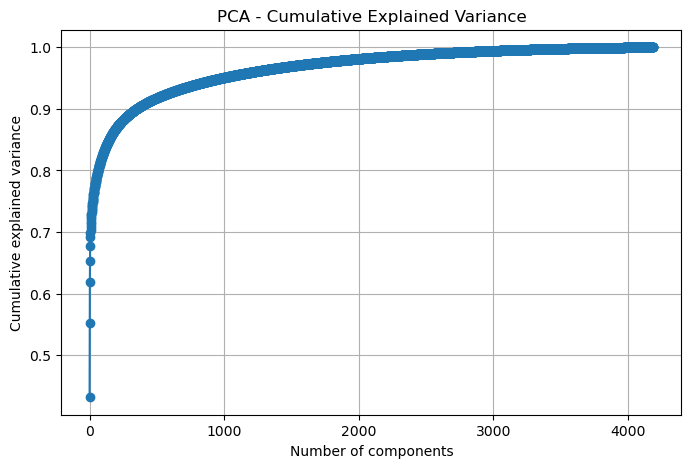

Number of components to retain 95% variance: 1939
Shape of X_train after PCA: (4188, 1939)


In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Suppose X_train is your flattened image data: shape (num_samples, num_features)
# Step 1: Standardize features (optional for PCA)
X_train_std = X_train - np.mean(X_train, axis=0)

# Step 2: Fit PCA
pca = PCA()  # fit all components first to see variance
pca.fit(X_train_std)

# Step 3: Explained variance
explained_variance = pca.explained_variance_ratio_

# Step 4: Cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Step 5: Plot cumulative variance
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Optional: choose number of components to explain e.g., 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.98) + 1
print(f"Number of components to retain 95% variance: {n_components_95}")

# Step 6: Transform dataset using selected number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_std)

print("Shape of X_train after PCA:", X_train_pca.shape)


Building layers of neural network where :
1. optimzer: Adam Optimizer
2. Architecture of the neural network = 40,000 → 8,000 → 4,000 → 2,000 → 1,000 → 500 → 256 → 128 → 2
3. Dropout = 0.2(20%)

In [82]:
print(X_train_pca.shape, y_train.shape)

(4188, 3) (4188,)


In [26]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2 / in_dim)
        self.b = np.zeros((out_dim,))

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out, l2=0.0):
        self.dW = self.x.T @ grad_out + l2*self.W
        self.db = np.sum(grad_out, axis=0)
        return grad_out @ self.W.T


In [27]:
class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask

In [28]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(pred, y):
    N = y.shape[0]
    p = pred[range(N), y]
    return -np.mean(np.log(p + 1e-12))

def softmax_backward(pred, y):
    grad = pred.copy()
    grad[np.arange(len(y)), y] -= 1
    return grad / len(y)


In [ ]:
class Dropout:
    def __init__(self, p=0.2):
        self.p = p
        self.mask = None

    def forward(self, x, training=True):
        if training:
            # keep probability
            keep = 1 - self.p
            self.mask = (np.random.rand(*x.shape) < keep).astype(float)
            return x * self.mask   # NO SCALING
        else:
            # scale down activations at inference
            return x * (1 - self.p)

    def backward(self, grad_out):
        # only pass gradients through kept units
        return grad_out * self.mask


In [30]:
class SimpleNN:
    def __init__(self, input_dim, output_dim=2, dropout_p=0.2):
        # Define layers
        self.l1 = Linear(input_dim, 2048)
        self.a1 = ReLU()
        self.d1 = Dropout(p=dropout_p)

        self.l2 = Linear(2048, 512)
        self.a2 = ReLU()
        self.d2 = Dropout(p=dropout_p)

        self.l3 = Linear(512, output_dim)  # output layer (no activation, no dropout)
        self.layers = [self.l1, self.l2, self.l3]

    def forward(self, x, training=True):
        z1 = self.l1.forward(x)
        a1 = self.a1.forward(z1)
        d1 = self.d1.forward(a1, training=training)

        z2 = self.l2.forward(d1)
        a2 = self.a2.forward(z2)
        d2 = self.d2.forward(a2, training=training)

        z3 = self.l3.forward(d2)
        return z3  # logits

    def backward(self, grad, l2=0.0):
        grad = self.l3.backward(grad, l2=l2)

        grad = self.d2.backward(grad)
        grad = self.a2.backward(grad)
        grad = self.l2.backward(grad, l2=l2)

        grad = self.d1.backward(grad)
        grad = self.a1.backward(grad)
        grad = self.l1.backward(grad, l2=l2)

        return grad

    def update(self, lr):
        for layer in [self.l1, self.l2, self.l3]:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db

    def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [31]:
def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['normal', 'abnormal']):
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # write numbers inside boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [32]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [38]:
def get_batches(X, y, batch_size=64, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Mini-batch generator
def get_batches(X, y, batch_size=64, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

def train(model, X_train, y_train, X_test, y_test, lr=0.001, epochs=25, l2=0.0, batch_size=64):

    history = {
        "loss": [],
        "train_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):
        epoch_loss = 0
        n_samples = 0

        # --- Mini-batch training ---
        for X_batch, y_batch in get_batches(X_train, y_train, batch_size=batch_size):
            # Forward
            logits = model.forward(X_batch, training=True)
            probs = softmax(logits)

            # Loss
            loss = cross_entropy(probs, y_batch)
            loss += (l2/2) * sum(np.sum(layer.W**2) for layer in model.layers)
            epoch_loss += loss * X_batch.shape[0]
            n_samples += X_batch.shape[0]

            # Backward
            grad = softmax_backward(probs, y_batch)
            model.backward(grad, l2=l2)

            # Update
            model.update(lr)

        # Average loss over the epoch
        epoch_loss /= n_samples

        # --- Evaluate metrics on full train/test sets ---
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        train_acc = accuracy(y_train, train_preds)
        test_acc = accuracy(y_test, test_preds)

        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        # Save history
        history["loss"].append(epoch_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}  Loss={epoch_loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # --- Final evaluation ---
    final_train_preds = model.predict(X_train)
    final_test_preds = model.predict(X_test)
    final_train_acc = accuracy(y_train, final_train_preds)
    final_test_acc  = accuracy(y_test, final_test_preds)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {final_train_acc:.4f}")
    print(f"Test Accuracy  : {final_test_acc:.4f}")

    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)
    plot_confusion_matrix(cm)

    return history


In [35]:
def model_summary(model):
    print("Layer (type)        Input → Output       # Parameters")
    print("-"*50)
    total_params = 0
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim
        total_params += params
        layer_type = "Linear"
        print(f"{i+1:2d} ({layer_type:<6})     {in_dim} → {out_dim:<6}     {params}")
    print("-"*50)
    print(f"Total parameters: {total_params}")


In [40]:
model_summary(model)

Layer (type)        Input → Output       # Parameters
--------------------------------------------------
 1 (Linear)     16384 → 2048       33556480
 2 (Linear)     2048 → 512        1049088
 3 (Linear)     512 → 2          1026
--------------------------------------------------
Total parameters: 34606594


In [39]:
model = SimpleNN(input_dim=X_train.shape[1], output_dim=2, dropout_p=0.2)

In [140]:
X_train_pca.shape

(4188, 1939)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30  Loss=0.9929  TrainAcc=0.4955  TestAcc=0.4776  Prec=0.2388  Recall=0.5000  F1=0.3232
Epoch 2/30  Loss=0.6932  TrainAcc=0.6017  TestAcc=0.6046  Prec=0.6056  Recall=0.5991  F1=0.5957
Epoch 3/30  Loss=0.6924  TrainAcc=0.5974  TestAcc=0.5769  Prec=0.7651  Recall=0.5951  F1=0.5063
Epoch 4/30  Loss=0.6876  TrainAcc=0.5922  TestAcc=0.5673  Prec=0.7623  Recall=0.5859  F1=0.4908
Epoch 5/30  Loss=0.6819  TrainAcc=0.4986  TestAcc=0.4804  Prec=0.7395  Recall=0.5027  F1=0.3293


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/30  Loss=0.6708  TrainAcc=0.5045  TestAcc=0.5224  Prec=0.2612  Recall=0.5000  F1=0.3432


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/30  Loss=0.6774  TrainAcc=0.5043  TestAcc=0.5224  Prec=0.2612  Recall=0.5000  F1=0.3432
Epoch 8/30  Loss=0.6670  TrainAcc=0.5298  TestAcc=0.5062  Prec=0.7458  Recall=0.5274  F1=0.3816
Epoch 9/30  Loss=0.6663  TrainAcc=0.5012  TestAcc=0.5205  Prec=0.3858  Recall=0.4983  F1=0.3441
Epoch 10/30  Loss=0.6536  TrainAcc=0.5905  TestAcc=0.5683  Prec=0.7626  Recall=0.5868  F1=0.4923
Epoch 11/30  Loss=0.6537  TrainAcc=0.6514  TestAcc=0.6686  Prec=0.6696  Recall=0.6698  F1=0.6686
Epoch 12/30  Loss=0.6477  TrainAcc=0.6877  TestAcc=0.6839  Prec=0.7149  Recall=0.6917  F1=0.6772
Epoch 13/30  Loss=0.6564  TrainAcc=0.5845  TestAcc=0.5616  Prec=0.7607  Recall=0.5804  F1=0.4813
Epoch 14/30  Loss=0.6537  TrainAcc=0.5036  TestAcc=0.5186  Prec=0.4942  Recall=0.4987  F1=0.3857
Epoch 15/30  Loss=0.6520  TrainAcc=0.6834  TestAcc=0.6734  Prec=0.7569  Recall=0.6856  F1=0.6531
Epoch 16/30  Loss=0.6491  TrainAcc=0.6834  TestAcc=0.6734  Prec=0.7523  Recall=0.6853  F1=0.6541
Epoch 17/30  Loss=0.6377  TrainAc

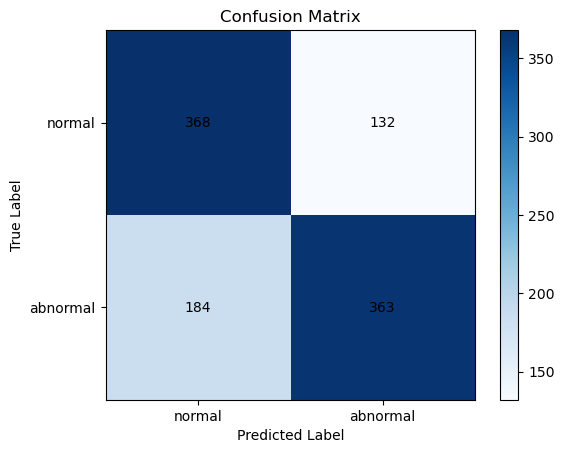

In [41]:
history = train(
    model, 
    X_train, y_train, 
    X_test, y_test,
    lr=0.02,       # learning rate
    epochs=30,      # number of epochs
    l2=0.00      # L2 regularization strength

)


In [84]:
X_test_std = X_test - np.mean(X_train, axis=0)  # use train mean
X_test_pca = pca.transform(X_test_std)


In [85]:
print(X_test_pca.shape)

(1047, 1939)


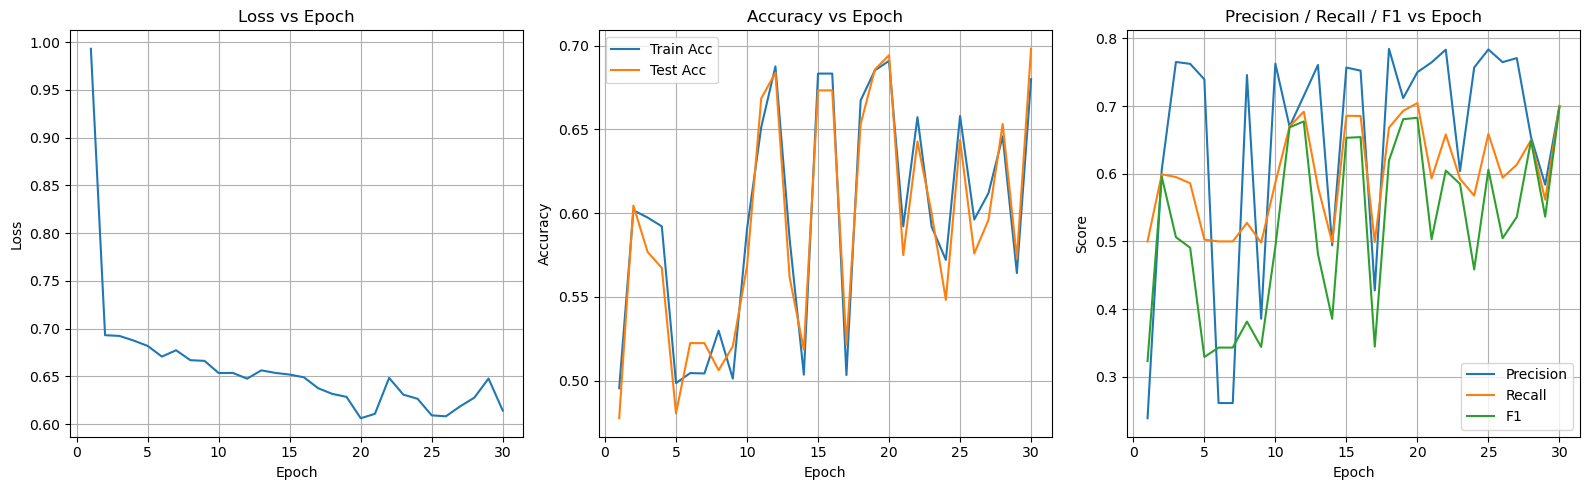

In [42]:
plot_metrics(history)


In [ ]:
plot_metrics(history)